In [1]:
from IPython.core.magic import register_cell_magic
from IPython.core.magic import register_line_magic

import time
import requests
import json
import time

In [2]:
current_agent_info = None

In [54]:
current_agent_info

{'agentId': 'agent_ba91240a-3e3d-4f15-8aac-207ba7f36b8b',
 'experimentId': 'CS_Agent_7c607c7f-c1af-485f-b883-3eff3f54e89e'}

In [115]:
! pip install pyjwt

  Obtaining dependency information for pyjwt from https://files.pythonhosted.org/packages/2b/4f/e04a8067c7c96c364cef7ef73906504e2f40d690811c021e1a1901473a19/PyJWT-2.8.0-py3-none-any.whl.metadata
  Using cached PyJWT-2.8.0-py3-none-any.whl.metadata (4.2 kB)
Using cached PyJWT-2.8.0-py3-none-any.whl (22 kB)

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [99]:
from IPython.core.magic import register_cell_magic
from IPython.core.magic import register_line_magic

from IPython.display import display, Image
import base64
import requests
import json
import jwt
import time
from pathlib import Path

current_agent_info = None

EXPLICIT_TOKEN_FILE = (
    Path(os.path.expanduser("~")) / "csagent" / "token" / "keys.json"
)

def read_explicit_token_file():
    if not EXPLICIT_TOKEN_FILE.exists():
        return None
    else:
        with open(EXPLICIT_TOKEN_FILE, "r") as f:
            return json.load(f)

def get_access_token():
    expl_token_data = read_explicit_token_file()
    if expl_token_data:
        return expl_token_data["access_token"]
    
def get_agent_status():
    global current_agent_info
    
    if not current_agent_info:
        print("No agent was scheduled yet. Please run %init_remote cluster=<cluster> cpu=<cpu> memory=<memory mb> queue=<queue> walltime=<walltime minutes>")
        return
        
    url = 'http://scigap02.sciencegateways.iu.edu:18880/api/v1/agent/' + current_agent_info['agentId']
    response = requests.get(url)
    if response.status_code == 202:
        return response.json()
    else:
        print('Invalid response reveived. Status code:', response.status_code)
        print('Response:', response.text)
    
def submit_agent_job(experiment_name, cluster, queue, cpus, memory, wallTime, access_token, gateway_id='testdrive'):

    global current_agent_info
    # URL to which the POST request will be sent
    url = 'http://scigap02.sciencegateways.iu.edu:18880/api/v1/exp/launch'

    # Data to be sent in the POST request
    data = {
        'experimentName': experiment_name,
        'remoteCluster': cluster,
        'cpuCount': cpus,
        'nodeCount': 1,
        'memory': memory,
        'wallTime': wallTime,
        'queue': queue
    }
    
    # Convert the data to JSON format
    json_data = json.dumps(data)

    decode = jwt.decode(access_token, options={"verify_signature": False})
    user_id = decode['preferred_username']
    claimsMap = {
        "userName": user_id,
        "gatewayID": gateway_id
    }
    
    # Headers
    headers = {
        'Content-Type': 'application/json',
        'Authorization': 'Bearer ' + access_token,
        'X-Claims': json.dumps(claimsMap)
    }
    
    # Send the POST request
    response = requests.post(url, headers=headers, data=json_data)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        response_data = response.json()
        print('Response:', response_data)
        current_agent_info = response_data
    else:
        print('Failed to send POST request. Status code:', response.status_code)
        print('Response:', response.text)

def terminate_agent(access_token, gateway_id='testdrive'):

    global current_agent_info
    
    expId = current_agent_info['experimentId']
    url = 'http://scigap02.sciencegateways.iu.edu:18880/api/v1/exp/terminate/' + expId

    decode = jwt.decode(access_token, options={"verify_signature": False})
    user_id = decode['preferred_username']
    claimsMap = {
        "userName": user_id,
        "gatewayID": gateway_id
    }
    
    # Headers
    headers = {
        'Content-Type': 'application/json',
        'Authorization': 'Bearer ' + access_token,
        'X-Claims': json.dumps(claimsMap)
    }
    
    # Send the POST request
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # Parse the JSON response
        response_data = response.json()
        print('Agent terminated:', response_data)
        current_agent_info = None
    else:
        print('Failed to send termination request. Status code:', response.status_code)
        print('Response:', response.text)


@register_cell_magic
def run_remote(line, cell):

    global current_agent_info
    if not current_agent_info:
        print("No agent was scheduled yet. Please run %init_remote cluster=<cluster> cpu=<cpu> memory=<memory mb> queue=<queue> walltime=<walltime minutes>")

    url = 'http://scigap02.sciencegateways.iu.edu:18880/api/v1/agent/executejupyterrequest'
    
    data = {
        "sessionId": "session1",
        "keepAlive": True,
        "code": cell,
        "agentId": current_agent_info["agentId"]
    }

    json_data = json.dumps(data)    
    response = requests.post(url, headers={'Content-Type': 'application/json'}, data=json_data)
    execution_resp = response.json()
    execution_id = execution_resp["executionId"]
    error = execution_resp["error"]
    if error:
        print("Cell execution failed. Error: " + error)
    if execution_id:
        while True:
            url = "http://scigap02.sciencegateways.iu.edu:18880/api/v1/agent/executejupyterresponse/" + execution_id
            response = requests.get(url, headers={'Accept': 'application/json'})
            json_response = response.json()
            #print(json_response)
            if json_response['available']:
                result_str = json_response['responseString']
                result = json.loads(result_str)
                if 'result' in result:
                    print(result['result'])
                elif 'error' in result:
                    print(result['error']['ename'])
                    print(result['error']['evalue'])
                    print(result['error']['traceback'])
                elif 'display' in result:
                    display_obj = result['display']
                    if 'data' in display_obj:
                        data_obj = display_obj['data']
                        if 'image/png' in data_obj:
                            image_data = data_obj['image/png']
                            display(Image(data=base64.b64decode(image_data), format='png'))
                break
            time.sleep(1)

@register_line_magic
def init_remote(line):

    if current_agent_info:
        status = get_agent_status()
        if status:
            if status['agentUp']:
                print("An agent is already running. Please terminate it first by running %terminate_remote")
                return
            else:
                print("An agent was scheduled. Please terminate it first by running %terminate_remote")
                return
                
    access_token = get_access_token()
    pairs = line.split()

    # Initialize variable to store the cluster value
    cluster_value = None
    memory_value = None
    cpu_value = None
    queue_value = None
    walltime_value = None
    
    # Iterate through the pairs to find the cluster value
    for pair in pairs:
        if pair.startswith("cluster="):
            cluster_value = pair.split("=")[1]
        if pair.startswith("cpu="):
            cpu_value = pair.split("=")[1]
        if pair.startswith("memory="):
            memory_value = pair.split("=")[1]
        if pair.startswith("queue="):
            queue_value = pair.split("=")[1]
        if pair.startswith("walltime="):
            walltime_value = pair.split("=")[1]
    
    submit_agent_job('CS Agent', cluster_value, queue_value, cpu_value, memory_value, walltime_value, access_token)

@register_line_magic
def status_remote(line):
    status = get_agent_status()
    if status:
        if status['agentUp']:
            print("Agent", status['agentId'], 'is running')
        else:
            print("Agent", status['agentId'], 'is still prepairing. Please wait')

@register_line_magic
def terminate_remote(line):
    global current_agent_info
    access_token = get_access_token()
    if current_agent_info:
        terminate_agent(access_token)

In [117]:
%init_remote cluster=expanse cpu=2 memory=2024 queue=shared walltime=60

Your input: cluster=expanse cpu=2 memory=2024 queue=shared walltime=60
Response: {'agentId': 'agent_e26bfeb7-f76a-4166-9a21-af76d0a713d4', 'experimentId': 'CS_Agent_dcdd52d1-b5c9-4318-b08f-450fa625e671'}


In [118]:
%status_remote

Agent agent_e26bfeb7-f76a-4166-9a21-af76d0a713d4 is running


In [119]:
%%run_remote
# Your code here
a = 10
print(a)

10



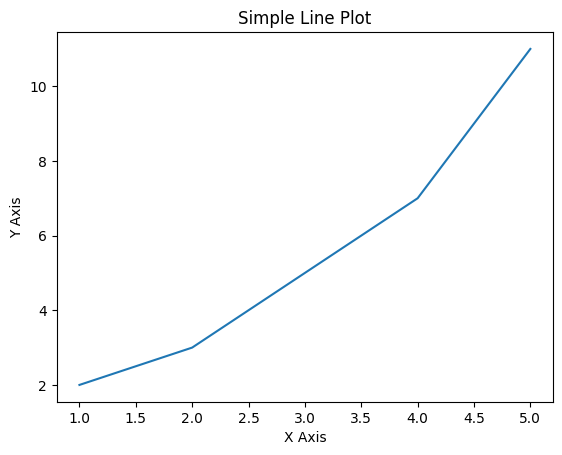

In [120]:
%%run_remote
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]

# Create the plot
plt.plot(x, y)

# Add a title and labels
plt.title('Simple Line Plot')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# Show the plot
plt.show()

In [121]:
%%run_remote
!ls -al 

total 412
drwxr-x--- 22 scigap uot111     42 Jul 20 23:52 .
drwxr-xr-x  1 scigap uot111     60 Jul 21 15:38 ..
-rw-------  1 scigap uot111   1908 Jul 19 11:48 .Xauthority
-rw-------  1 scigap uot111  20517 Jul 20 23:52 .bash_history
-rw-r--r--  1 scigap uot111     18 Nov  8  2019 .bash_logout
-rw-r--r--  1 scigap uot111    141 Nov  8  2019 .bash_profile
-rw-r--r--  1 scigap uot111   1227 Sep 20  2023 .bashrc
drwx------  7 scigap uot111      7 Jun  6 14:05 .cache
drwxrwsr-x  4 scigap uot111      5 Jun  9  2023 .conda
drwxr-xr-x  3 scigap uot111      3 Sep  7  2022 .config
drwx------  3 scigap uot111      3 Jun  6 12:17 .dbus
-rw-r--r--  1 scigap uot111    334 May 11  2019 .emacs
-rw-r--r--  1 scigap uot111     18 Sep 20  2023 .gitconfig
drwxr-xr-x  3 scigap uot111      3 Jul 19 15:53 .ipython
-rw-r--r--  1 scigap uot111    172 Apr 23  2020 .kshrc
-rw-------  1 scigap uot111     38 Jun 23 12:39 .lesshst
drwxr-xr-x  3 scigap uot111      3 May 15  2023 .lmod.d
drwx------  5 scigap uot111  

In [97]:
%%run_remote
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip



In [122]:
%terminate_remote

Agent terminated: {'experimentId': 'CS_Agent_dcdd52d1-b5c9-4318-b08f-450fa625e671', 'terminated': True}
